In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
import tensorflow_datasets as tfds
from nltk.corpus import wordnet as wn
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import keract
from tqdm import tqdm
import pandas as pd
import seaborn as sns

from scipy import spatial


with_gpu = True
if not with_gpu:
    tf.config.experimental.set_visible_devices([], "GPU")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is Enabled")
else:
    print("GPU is not Enabled")
    

GPU is not Enabled


In [5]:
MODEL, DATASET = 'vgg16', 'imagenette'
model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet'
)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
ds, info = tfds.load(
    'imagenette/320px-v2',
    shuffle_files=False,
    with_info=True,
    as_supervised=True,
    batch_size=None,
)
labels = tfds.features.ClassLabel(
    names=list(map(lambda l: wn.synset_from_pos_and_offset(
        l[0], int(l[1:])).name(), info.features['label'].names))
)
vgg16_input_shape = tf.keras.applications.vgg16.VGG16().input.shape[1:3].as_list()
@tf.function
def preprocess(x, y):
    x = tf.image.resize(x, vgg16_input_shape, method=tf.image.ResizeMethod.BILINEAR)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    return x, y

In [6]:
model.evaluate(ds['validation'].map(preprocess).map(
        lambda x, y: (x, tf.one_hot(y, 1000))
    ).batch(32),
    return_dict=True
)

123/123 [==============================] - 164s 1s/step - loss: 16.7779 - categorical_accuracy: 0.0864 - top_k_categorical_accuracy: 0.0945


{'loss': 16.777862548828125,
 'categorical_accuracy': 0.08636942505836487,
 'top_k_categorical_accuracy': 0.09452228993177414}

In [ ]:
evals = {'block1_conv2': {1: {'loss': 1.4357656240463257},
  11: {'loss': 1.612860918045044},
  21: {'loss': 2.683134078979492},
  31: {'loss': 6.335630416870117},
  41: {'loss': 6.047577381134033}},
 'block5_conv2': {1: {'loss': 1.4259768724441528},
  11: {'loss': 1.4499014616012573},
  21: {'loss': 1.4771815538406372},
  31: {'loss': 1.5210167169570923},
  41: {'loss': 1.5465093851089478}},
 'block2_conv1': {1: {'loss': 1.4246597290039062},
  11: {'loss': 1.5066274404525757},
  21: {'loss': 1.8338731527328491},
  31: {'loss': 2.5834293365478516},
  41: {'loss': 2.375235080718994}},
 'block3_conv1': {1: {'loss': 1.4361662864685059},
  11: {'loss': 1.4596874713897705},
  21: {'loss': 1.494843602180481},
  31: {'loss': 1.673970103263855},
  41: {'loss': 1.619691252708435}}}

In [7]:
def delete_cnn_layer_channel(model, layer_name, next_layer_name, channel_indices, model_input_shape):
    model.build(model_input_shape)
    layer = model.get_layer(layer_name)
    weights, biases = layer.get_weights()
    previous_layer_name = layer.input.name.split('/')[0]  # Get the name of the previous layer
    previous_layer = model.get_layer(previous_layer_name)
    next_layer = model.get_layer(next_layer_name)
    
    new_cnn_layer = tf.keras.layers.Conv2D(layer.filters-len(channel_indices), layer.kernel_size, activation=layer.activation, padding=layer.padding, input_shape=previous_layer.output_shape[1:], name=layer_name, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))
    new_next_cnn_layer = tf.keras.layers.Conv2D(next_layer.filters, next_layer.kernel_size, activation=next_layer.activation, padding=next_layer.padding, name=next_layer_name, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))

    # Create a new model and replace the desired layer with the modified layer
    new_model = tf.keras.models.Sequential()
    for layer in model.layers:
        if layer.name == layer_name:
            new_model.add(new_cnn_layer)
        elif layer.name == next_layer_name:
            new_model.add(new_next_cnn_layer)
        else:
            new_model.add(layer)
            
    total_random = sum([1 for c in channel_indices if c == 'random'])
    randoms = np.random.default_rng().choice(weights.shape[3], total_random, replace=False)
    j = 0
    for i, c in enumerate(channel_indices):
        if c == 'random':
            channel_indices[i] = randoms[j]
            j += 1
    if len(randoms) > 0:
        print(f"Deleting channels {channel_indices}")
    del randoms
    del total_random
    del j
    for c in channel_indices:
        assert c < weights.shape[3], "Channel index out of range"
    assert len(channel_indices) == len(set(channel_indices)), "Duplicate channel indices"
    
    
    new_weights = np.delete(weights, channel_indices, axis=3)
    new_biases = np.delete(biases, channel_indices)
    
    new_layer_names = [layer.name for layer in new_model.layers]
    new_layer_idx = new_layer_names.index(layer_name)
    new_model.layers[new_layer_idx].build(previous_layer.output_shape)
    new_model.layers[new_layer_idx].set_weights([new_weights, new_biases])

    next_weights, next_biases = next_layer.get_weights()
    new_next_weights = np.delete(next_weights, channel_indices, axis=2)
    new_next_layer_idx = new_layer_names.index(next_layer_name)
    new_model.layers[new_next_layer_idx].build((*model.get_layer(layer_name).output_shape[:3], model.get_layer(layer_name).filters-len(channel_indices)))
    new_model.layers[new_next_layer_idx].set_weights([new_next_weights, next_biases])
    # for layer in new_model.layers:
    new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
    return new_model


In [ ]:
cur_evals = {}
layers = ['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2', 'block5_conv2']
channels_count = [64, 128, 256, 512, 512]
next_Layers = ['block2_conv1', 'block3_conv1', 'block3_conv3', 'block4_conv3', 'block5_conv3']
percent = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for layer, channels, next_layer in zip(layers, channels_count, next_Layers):
    if layer not in cur_evals:
        cur_evals[layer] = {}
    for p in percent:
        new_model = delete_cnn_layer_channel(model, layer, next_layer, channel_indices=['random']*int(channels*p))

        cur_evals[layer][p] = new_model.evaluate(ds['validation'].map(preprocess).map(
                lambda x, y: (x, tf.one_hot(y, 1000))
            ).batch(64))
    
cur_evals

Deleting channels [23, 48, 16, 19, 60, 37]


2023-06-29 20:55:48.542386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]
2023-06-29 20:55:48.542589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 230s 294ms/step - loss: 1.5703
Deleting channels [26, 17, 27, 21, 7, 29, 43, 12, 59, 60, 39, 48]


2023-06-29 20:59:38.887782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]
2023-06-29 20:59:38.887983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]


782/782 [==============================] - 222s 279ms/step - loss: 1.6765
Deleting channels [48, 35, 7, 36, 39, 60, 27, 51, 13, 1, 26, 2, 16, 28, 52, 37, 24, 22, 54]


2023-06-29 21:03:21.139744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]
2023-06-29 21:03:21.139949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]


782/782 [==============================] - 221s 279ms/step - loss: 2.1365
Deleting channels [6, 12, 50, 47, 38, 28, 54, 18, 43, 26, 40, 37, 52, 41, 22, 23, 55, 63, 14, 39, 35, 44, 49, 24, 9]


2023-06-29 21:07:02.645652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]
2023-06-29 21:07:02.645856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 218s 275ms/step - loss: 2.0130
Deleting channels [48, 12, 46, 10, 25, 36, 47, 21, 42, 53, 30, 35, 13, 4, 18, 31, 22, 9, 27, 58, 59, 33, 0, 45, 24, 19, 51, 50, 40, 28, 16, 57]


2023-06-29 21:10:40.863796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 21:10:40.864000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 200s 252ms/step - loss: 4.5885
Deleting channels [27, 14, 39, 30, 15, 33, 38, 9, 1, 18, 47, 12, 34, 0, 11, 35, 45, 48, 57, 42, 4, 61, 51, 52, 13, 5, 37, 43, 46, 17, 56, 40, 63, 49, 31, 16, 3, 21]


2023-06-29 21:14:00.484453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]
2023-06-29 21:14:00.484667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 197s 248ms/step - loss: 6.2643
Deleting channels [1, 43, 0, 56, 24, 18, 61, 8, 34, 30, 28, 62, 27, 57, 46, 13, 15, 11, 51, 14, 52, 54, 39, 6, 53, 3, 37, 44, 47, 23, 2, 9, 29, 45, 25, 41, 5, 16, 21, 36, 19, 10, 20, 35]


2023-06-29 21:17:17.287021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 21:17:17.287231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 194s 245ms/step - loss: 5.2853
Deleting channels [28, 47, 9, 13, 63, 49, 36, 7, 52, 45, 54, 3, 39, 30, 12, 40, 44, 46, 26, 18, 29, 43, 19, 37, 42, 33, 22, 62, 11, 58, 14, 25, 51, 2, 50, 20, 31, 35, 15, 53, 1, 41, 17, 55, 23, 32, 5, 59, 24, 10, 38]


2023-06-29 21:20:31.326456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]
2023-06-29 21:20:31.326658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 189s 240ms/step - loss: 6.9779
Deleting channels [2, 20, 50, 25, 30, 12, 16, 3, 11, 24, 36, 51, 34, 23, 58, 37, 6, 56, 19, 60, 8, 41, 53, 15, 14, 38, 52, 48, 61, 26, 22, 28, 18, 0, 57, 43, 54, 62, 42, 31, 17, 49, 29, 4, 7, 13, 33, 21, 32, 9, 27, 55, 35, 10, 46, 40, 39]


2023-06-29 21:23:40.624596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 21:23:40.624803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 193s 245ms/step - loss: 7.5576
Deleting channels [44, 17, 26, 81, 126, 97, 54, 21, 46, 1, 107, 70]


2023-06-29 21:26:54.180657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]
2023-06-29 21:26:54.180873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]


782/782 [==============================] - 232s 294ms/step - loss: 1.6504
Deleting channels [1, 27, 91, 121, 98, 69, 41, 76, 117, 74, 52, 122, 29, 119, 47, 37, 54, 3, 6, 14, 70, 97, 110, 26, 0]


2023-06-29 21:30:46.472692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 21:30:46.472893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 217s 278ms/step - loss: 3.0300
Deleting channels [102, 74, 119, 8, 7, 17, 18, 72, 93, 88, 67, 4, 91, 1, 120, 90, 20, 51, 28, 47, 92, 81, 123, 27, 31, 19, 111, 52, 126, 73, 16, 55, 15, 69, 54, 43, 65, 115]


2023-06-29 21:34:23.872722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]
2023-06-29 21:34:23.872927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]


782/782 [==============================] - 215s 272ms/step - loss: 4.2105
Deleting channels [107, 34, 25, 68, 17, 119, 63, 96, 2, 81, 59, 27, 9, 4, 45, 100, 49, 13, 46, 94, 110, 67, 87, 106, 41, 3, 126, 77, 91, 92, 39, 103, 31, 20, 7, 10, 66, 105, 74, 98, 28, 122, 79, 89, 51, 70, 78, 58, 57, 62, 116]


2023-06-29 21:37:58.565848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]
2023-06-29 21:37:58.566047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]


782/782 [==============================] - 215s 272ms/step - loss: 7.5660
Deleting channels [113, 1, 90, 21, 81, 27, 63, 69, 10, 79, 17, 15, 95, 60, 43, 56, 61, 88, 120, 103, 96, 28, 48, 39, 114, 19, 54, 6, 33, 57, 94, 18, 42, 125, 107, 9, 85, 64, 89, 101, 98, 87, 124, 127, 121, 37, 36, 93, 26, 115, 76, 31, 11, 13, 126, 38, 14, 122, 34, 109, 86, 116, 52, 47]


2023-06-29 21:41:33.617089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]
2023-06-29 21:41:33.617291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 203s 257ms/step - loss: 5.5443
Deleting channels [47, 38, 0, 78, 66, 127, 29, 83, 56, 48, 12, 79, 37, 80, 119, 10, 41, 95, 117, 43, 44, 81, 103, 2, 125, 15, 84, 40, 42, 21, 76, 89, 82, 26, 50, 54, 53, 25, 8, 88, 70, 120, 11, 59, 85, 49, 58, 61, 86, 65, 116, 72, 114, 68, 52, 121, 109, 115, 118, 13, 62, 60, 110, 106, 22, 97, 91, 93, 16, 4, 101, 126, 75, 77, 31, 100]


2023-06-29 21:44:56.346378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 21:44:56.346648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 204s 259ms/step - loss: 6.0263
Deleting channels [32, 55, 34, 10, 57, 41, 46, 68, 127, 3, 103, 89, 75, 102, 26, 42, 7, 1, 28, 100, 78, 37, 105, 118, 60, 81, 58, 49, 40, 50, 23, 104, 109, 31, 38, 56, 123, 85, 83, 113, 117, 14, 121, 11, 96, 36, 19, 82, 126, 67, 72, 66, 53, 71, 69, 30, 61, 45, 18, 125, 0, 9, 35, 97, 91, 93, 95, 15, 80, 59, 110, 114, 107, 52, 51, 2, 124, 106, 33, 24, 43, 111, 22, 108, 70, 94, 25, 12, 76]


2023-06-29 21:48:20.867112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]
2023-06-29 21:48:20.867316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]


782/782 [==============================] - 201s 255ms/step - loss: 8.1713
Deleting channels [36, 108, 55, 77, 114, 42, 89, 84, 43, 17, 86, 72, 99, 24, 121, 45, 124, 47, 118, 125, 48, 27, 83, 50, 6, 65, 70, 30, 56, 22, 44, 31, 120, 87, 111, 13, 115, 53, 21, 112, 79, 61, 11, 102, 103, 25, 58, 71, 127, 32, 98, 57, 28, 51, 3, 5, 67, 18, 2, 52, 106, 91, 113, 20, 4, 116, 126, 73, 74, 85, 119, 54, 90, 15, 0, 97, 12, 110, 117, 38, 49, 95, 23, 101, 9, 81, 46, 82, 60, 59, 122, 14, 19, 94, 76, 41, 69, 107, 16, 68, 33, 80]


2023-06-29 21:51:41.674939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 21:51:41.675148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 190s 242ms/step - loss: 7.5655
Deleting channels [89, 115, 105, 39, 111, 70, 101, 49, 124, 48, 67, 51, 91, 85, 65, 84, 34, 82, 71, 26, 10, 87, 63, 30, 15, 44, 106, 114, 16, 72, 24, 125, 19, 74, 94, 6, 5, 40, 64, 9, 112, 52, 7, 3, 25, 37, 97, 102, 116, 73, 29, 110, 17, 98, 46, 120, 22, 56, 54, 4, 55, 42, 83, 93, 36, 119, 76, 96, 57, 43, 32, 117, 13, 68, 14, 23, 86, 41, 18, 99, 31, 38, 20, 118, 8, 11, 27, 62, 113, 123, 104, 88, 121, 2, 28, 127, 45, 92, 0, 35, 109, 53, 66, 77, 80, 1, 50, 58, 81, 69, 95, 108, 79, 90, 107]


2023-06-29 21:54:52.027926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]
2023-06-29 21:54:52.028200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 187s 238ms/step - loss: 9.0444
Deleting channels [201, 95, 148, 129, 17, 113, 61, 171, 174, 159, 89, 223, 76, 150, 192, 144, 189, 185, 52, 232, 147, 33, 42, 183, 97]


2023-06-29 21:57:59.549139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 21:57:59.549343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]


782/782 [==============================] - 226s 285ms/step - loss: 1.5174
Deleting channels [149, 97, 37, 225, 217, 31, 35, 237, 56, 74, 212, 122, 127, 170, 64, 216, 165, 8, 120, 214, 208, 169, 19, 42, 220, 183, 197, 52, 219, 139, 45, 238, 137, 114, 233, 181, 96, 162, 116, 98, 150, 213, 178, 188, 5, 59, 34, 49, 118, 202, 252]


2023-06-29 22:01:45.392826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]
2023-06-29 22:01:45.393032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 225s 284ms/step - loss: 1.6794
Deleting channels [90, 74, 171, 162, 93, 86, 111, 11, 59, 95, 227, 56, 147, 201, 30, 120, 97, 76, 136, 49, 20, 241, 5, 25, 253, 117, 143, 251, 108, 55, 91, 82, 63, 84, 72, 35, 200, 34, 128, 22, 12, 151, 103, 232, 92, 24, 185, 168, 116, 57, 69, 101, 66, 213, 119, 223, 133, 230, 218, 248, 254, 78, 216, 1, 122, 144, 180, 165, 0, 139, 210, 104, 195, 194, 186, 239]


2023-06-29 22:05:30.359343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 22:05:30.359558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 203s 259ms/step - loss: 1.9179
Deleting channels [66, 182, 77, 139, 179, 16, 95, 189, 39, 210, 109, 146, 208, 14, 72, 211, 237, 169, 176, 23, 213, 232, 197, 253, 116, 50, 196, 243, 241, 152, 154, 183, 224, 53, 106, 35, 8, 105, 34, 58, 236, 101, 100, 85, 64, 91, 49, 167, 247, 193, 102, 201, 230, 142, 240, 81, 126, 161, 47, 107, 5, 70, 57, 25, 99, 251, 60, 87, 222, 234, 200, 133, 228, 223, 37, 96, 217, 45, 216, 6, 172, 110, 20, 1, 163, 135, 18, 143, 68, 123, 67, 215, 252, 191, 78, 108, 9, 178, 207, 103, 52, 144]


2023-06-29 22:08:53.000066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]
2023-06-29 22:08:53.000271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 207s 262ms/step - loss: 2.2746
Deleting channels [41, 5, 229, 6, 158, 179, 97, 61, 251, 248, 51, 100, 212, 190, 250, 98, 77, 245, 232, 16, 82, 253, 140, 2, 3, 231, 173, 130, 147, 225, 34, 249, 83, 228, 56, 166, 84, 198, 18, 87, 139, 246, 108, 1, 221, 33, 209, 64, 58, 156, 186, 192, 93, 65, 138, 57, 163, 171, 104, 116, 91, 101, 63, 4, 74, 244, 191, 76, 185, 49, 17, 25, 8, 46, 21, 132, 237, 150, 175, 144, 62, 176, 197, 95, 226, 39, 152, 180, 154, 24, 213, 113, 194, 155, 184, 188, 204, 44, 203, 206, 181, 53, 60, 10, 141, 202, 94, 80, 105, 119, 111, 122, 38, 109, 220, 70, 124, 129, 214, 29, 224, 117, 255, 42, 215, 81, 172, 43]


2023-06-29 22:12:19.785969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 22:12:19.786174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 199s 253ms/step - loss: 2.8812
Deleting channels [23, 242, 111, 10, 68, 224, 227, 238, 174, 63, 216, 126, 169, 28, 94, 132, 212, 178, 6, 14, 46, 210, 171, 108, 83, 36, 98, 116, 97, 8, 13, 211, 133, 90, 81, 135, 230, 125, 166, 104, 161, 137, 139, 89, 56, 157, 251, 246, 218, 87, 234, 194, 19, 223, 80, 200, 59, 243, 76, 20, 5, 118, 22, 159, 141, 156, 51, 130, 38, 113, 129, 86, 143, 96, 237, 188, 254, 196, 187, 138, 9, 148, 30, 142, 213, 54, 53, 93, 241, 255, 248, 4, 119, 214, 91, 134, 120, 47, 24, 228, 15, 121, 32, 31, 184, 136, 69, 71, 191, 109, 165, 112, 75, 67, 177, 144, 50, 222, 78, 55, 245, 151, 123, 25, 101, 167, 40, 85, 201, 179, 208, 146, 105, 41, 34, 189, 21, 155, 26, 145, 225, 219, 106, 185, 65, 203, 18, 206, 221, 190, 0, 12, 115]


2023-06-29 22:15:39.197679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 22:15:39.197957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 195s 249ms/step - loss: 4.3548
Deleting channels [237, 49, 111, 36, 8, 87, 140, 232, 128, 131, 2, 134, 148, 17, 212, 0, 65, 92, 1, 209, 97, 189, 23, 245, 195, 125, 105, 45, 250, 83, 215, 102, 73, 44, 168, 10, 72, 12, 152, 147, 127, 63, 20, 116, 47, 157, 108, 78, 112, 13, 84, 231, 110, 18, 123, 175, 35, 241, 224, 139, 118, 254, 66, 246, 178, 26, 133, 50, 219, 124, 179, 226, 183, 253, 94, 239, 213, 25, 186, 6, 122, 202, 234, 169, 252, 143, 206, 96, 200, 117, 176, 227, 251, 29, 93, 22, 236, 218, 90, 149, 204, 58, 233, 135, 7, 164, 132, 180, 167, 70, 196, 155, 130, 39, 33, 192, 208, 244, 42, 229, 150, 217, 137, 28, 138, 4, 98, 126, 181, 173, 71, 207, 3, 31, 141, 170, 161, 188, 238, 21, 11, 101, 115, 146, 14, 52, 216, 248, 67, 100, 193, 144, 220, 194, 191, 199, 16, 88, 51, 163, 59, 37, 53, 145, 153, 41, 64, 190, 198, 30, 177, 151, 158, 109, 104, 184, 120, 154, 172]


2023-06-29 22:18:54.699024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 22:18:54.699226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]


782/782 [==============================] - 195s 248ms/step - loss: 4.8412
Deleting channels [65, 98, 129, 37, 105, 76, 57, 248, 66, 209, 36, 201, 143, 215, 47, 144, 202, 88, 114, 125, 19, 255, 137, 48, 92, 42, 154, 67, 237, 23, 147, 16, 85, 156, 72, 158, 126, 63, 14, 193, 175, 245, 18, 190, 188, 206, 75, 90, 203, 56, 179, 197, 77, 55, 123, 87, 163, 224, 106, 204, 64, 178, 168, 223, 102, 109, 15, 71, 252, 53, 116, 214, 99, 198, 241, 130, 151, 34, 51, 86, 30, 2, 131, 251, 26, 132, 80, 159, 35, 222, 111, 141, 112, 240, 183, 213, 94, 162, 184, 208, 97, 187, 161, 21, 235, 70, 232, 0, 124, 181, 117, 211, 127, 243, 200, 115, 82, 43, 84, 24, 230, 239, 194, 217, 177, 166, 101, 182, 216, 227, 229, 100, 138, 250, 38, 83, 110, 11, 58, 133, 62, 60, 5, 171, 1, 238, 218, 78, 28, 176, 12, 195, 45, 142, 226, 148, 31, 169, 205, 155, 3, 118, 79, 236, 139, 119, 33, 8, 103, 121, 164, 74, 40, 13, 146, 39, 174, 134, 220, 17, 157, 242, 249, 160, 96, 212, 152, 22, 68, 192, 247, 185, 196, 180, 254, 170, 150, 41

2023-06-29 22:22:09.721141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 22:22:09.721342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 212s 270ms/step - loss: 6.5341
Deleting channels [179, 53, 254, 64, 83, 159, 54, 57, 79, 84, 61, 242, 77, 96, 152, 73, 237, 220, 48, 132, 222, 199, 28, 200, 109, 55, 72, 195, 149, 177, 147, 162, 245, 216, 58, 29, 213, 248, 44, 157, 6, 194, 12, 202, 161, 238, 137, 17, 11, 232, 250, 81, 196, 240, 164, 140, 136, 94, 7, 43, 131, 100, 187, 63, 117, 36, 46, 102, 226, 178, 138, 180, 27, 59, 170, 9, 126, 3, 153, 134, 112, 0, 76, 218, 49, 167, 65, 91, 35, 139, 4, 198, 75, 128, 129, 208, 42, 127, 169, 215, 185, 67, 150, 229, 133, 50, 166, 233, 103, 99, 45, 31, 121, 192, 143, 151, 82, 33, 141, 191, 21, 19, 2, 70, 86, 15, 204, 56, 78, 113, 223, 236, 253, 183, 40, 122, 120, 209, 30, 114, 24, 205, 13, 1, 38, 224, 26, 219, 105, 34, 203, 93, 145, 212, 234, 92, 66, 241, 32, 228, 80, 101, 231, 181, 85, 146, 62, 171, 10, 88, 142, 87, 154, 74, 116, 182, 207, 246, 243, 172, 110, 52, 193, 95, 97, 18, 247, 175, 239, 20, 186, 190, 156, 225, 89, 119, 227, 201, 130, 60

2023-06-29 22:25:42.012387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 22:25:42.012595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]


782/782 [==============================] - 199s 253ms/step - loss: 8.1254
Deleting channels [330, 196, 242, 191, 119, 498, 132, 168, 500, 17, 255, 264, 279, 385, 131, 275, 409, 473, 236, 148, 506, 327, 280, 36, 219, 136, 429, 323, 394, 173, 216, 163, 42, 28, 388, 484, 203, 218, 312, 258, 167, 62, 343, 53, 194, 387, 183, 380, 401, 307, 308]


2023-06-29 22:29:01.064809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]
2023-06-29 22:29:01.065013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 224s 284ms/step - loss: 1.5071
Deleting channels [62, 93, 317, 178, 135, 271, 159, 25, 293, 468, 13, 258, 302, 28, 463, 76, 52, 330, 208, 257, 127, 436, 405, 351, 360, 239, 154, 470, 193, 341, 506, 44, 248, 49, 57, 386, 299, 365, 15, 200, 358, 8, 433, 11, 292, 190, 384, 58, 319, 67, 475, 235, 27, 260, 82, 455, 105, 471, 500, 65, 136, 382, 320, 79, 194, 490, 115, 61, 331, 39, 246, 265, 483, 141, 92, 278, 431, 205, 486, 268, 480, 295, 4, 374, 266, 339, 342, 491, 369, 362, 473, 261, 467, 66, 394, 364, 404, 226, 357, 10, 41, 289]


2023-06-29 22:32:45.298017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 22:32:45.298228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]


782/782 [==============================] - 225s 285ms/step - loss: 1.6709
Deleting channels [73, 258, 85, 337, 194, 431, 487, 414, 55, 79, 156, 9, 335, 175, 149, 16, 39, 463, 99, 369, 18, 372, 488, 245, 338, 489, 44, 65, 428, 470, 503, 237, 238, 379, 249, 203, 422, 229, 287, 111, 298, 334, 453, 281, 323, 376, 311, 484, 72, 86, 242, 267, 136, 100, 130, 105, 330, 215, 216, 302, 478, 206, 69, 404, 157, 224, 273, 35, 373, 447, 144, 236, 64, 271, 97, 253, 324, 439, 285, 331, 158, 251, 317, 115, 464, 80, 436, 448, 120, 184, 261, 477, 201, 327, 494, 288, 346, 92, 314, 366, 81, 322, 214, 458, 493, 382, 218, 67, 286, 313, 207, 415, 355, 332, 501, 117, 61, 385, 424, 350, 232, 90, 354, 473, 504, 89, 124, 219, 305, 398, 416, 113, 31, 187, 495, 178, 469, 127, 30, 240, 475, 352, 293, 406, 315, 507, 107, 150, 266, 185, 345, 170, 212]


2023-06-29 22:36:30.517730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 22:36:30.518000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 231s 293ms/step - loss: 1.8521
Deleting channels [97, 284, 244, 209, 427, 183, 308, 74, 208, 429, 50, 316, 235, 403, 287, 176, 193, 462, 48, 331, 202, 29, 8, 433, 150, 180, 438, 223, 171, 500, 445, 336, 229, 110, 392, 405, 196, 162, 434, 503, 471, 375, 157, 369, 256, 154, 166, 305, 149, 365, 335, 302, 102, 430, 71, 398, 487, 164, 81, 210, 132, 24, 41, 140, 72, 453, 390, 334, 416, 200, 142, 449, 227, 354, 131, 80, 501, 268, 353, 381, 111, 28, 45, 339, 311, 393, 402, 174, 42, 395, 418, 206, 103, 352, 303, 167, 33, 2, 10, 109, 379, 265, 219, 190, 409, 92, 226, 52, 313, 263, 342, 113, 286, 495, 486, 248, 412, 319, 87, 351, 0, 295, 37, 338, 489, 247, 214, 250, 493, 121, 407, 481, 117, 79, 396, 18, 165, 88, 406, 251, 199, 177, 362, 148, 99, 510, 160, 68, 382, 228, 437, 400, 371, 307, 205, 168, 198, 60, 276, 272, 91, 426, 498, 11, 506, 502, 281, 298, 182, 358, 139, 40, 383, 441, 315, 324, 266, 27, 258, 504, 271, 370, 475, 163, 136, 66, 114, 321, 203,

2023-06-29 22:40:21.407392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 22:40:21.407611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 226s 289ms/step - loss: 2.2217
Deleting channels [96, 360, 386, 122, 318, 44, 53, 351, 413, 146, 48, 294, 395, 362, 84, 438, 207, 281, 459, 366, 191, 80, 77, 24, 247, 346, 233, 269, 50, 321, 384, 190, 462, 15, 219, 400, 464, 478, 160, 435, 174, 242, 393, 226, 347, 300, 0, 156, 264, 348, 197, 424, 357, 62, 356, 456, 296, 98, 415, 28, 498, 54, 148, 423, 79, 86, 471, 31, 253, 59, 285, 463, 507, 444, 246, 324, 260, 465, 90, 1, 431, 243, 506, 237, 111, 477, 374, 161, 473, 173, 352, 317, 481, 218, 369, 484, 127, 164, 231, 251, 452, 358, 45, 254, 52, 255, 186, 349, 118, 411, 19, 306, 135, 320, 410, 128, 204, 225, 273, 316, 227, 47, 176, 114, 344, 278, 433, 210, 407, 178, 55, 21, 126, 261, 403, 106, 448, 494, 167, 272, 504, 8, 234, 332, 427, 353, 38, 200, 26, 327, 145, 503, 371, 263, 229, 290, 22, 36, 69, 112, 331, 40, 158, 140, 428, 195, 275, 476, 467, 282, 437, 279, 25, 222, 288, 373, 381, 232, 258, 277, 215, 63, 298, 182, 489, 450, 121, 359, 434, 4

2023-06-29 22:44:07.871340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 22:44:07.871608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]


782/782 [==============================] - 228s 290ms/step - loss: 2.6936
Deleting channels [480, 464, 86, 246, 386, 191, 282, 180, 253, 245, 505, 481, 382, 225, 341, 290, 313, 355, 154, 439, 216, 436, 461, 450, 118, 0, 299, 374, 219, 484, 250, 200, 304, 13, 220, 40, 317, 467, 447, 472, 10, 339, 53, 49, 31, 187, 379, 479, 221, 159, 502, 259, 17, 228, 135, 321, 105, 16, 395, 244, 501, 406, 115, 346, 149, 471, 431, 222, 138, 96, 336, 128, 286, 419, 482, 448, 328, 117, 203, 478, 354, 242, 312, 277, 194, 211, 132, 496, 358, 381, 91, 280, 422, 233, 163, 362, 376, 389, 238, 332, 284, 348, 111, 410, 146, 456, 32, 281, 177, 315, 19, 349, 368, 145, 223, 72, 150, 488, 509, 500, 161, 199, 66, 411, 104, 202, 124, 81, 48, 273, 130, 438, 248, 307, 492, 489, 6, 399, 258, 271, 106, 239, 442, 306, 158, 134, 97, 445, 333, 148, 460, 268, 369, 85, 162, 503, 195, 420, 9, 156, 120, 185, 357, 394, 240, 80, 14, 344, 1, 69, 184, 366, 136, 335, 84, 384, 345, 404, 95, 18, 267, 29, 4, 424, 465, 329, 15, 65, 440, 

2023-06-29 22:47:56.011481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 22:47:56.011764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 222s 282ms/step - loss: 2.9742
Deleting channels [425, 385, 9, 298, 195, 246, 431, 365, 221, 235, 32, 416, 322, 196, 314, 146, 185, 160, 144, 327, 157, 444, 374, 227, 257, 316, 499, 382, 394, 21, 283, 396, 87, 205, 383, 101, 263, 63, 336, 119, 443, 337, 265, 243, 173, 332, 201, 28, 49, 56, 177, 278, 350, 412, 317, 135, 500, 114, 154, 321, 133, 158, 479, 193, 213, 181, 58, 419, 0, 7, 487, 130, 357, 223, 292, 355, 456, 381, 325, 86, 182, 34, 100, 134, 417, 27, 506, 372, 387, 390, 55, 20, 24, 14, 115, 329, 61, 233, 65, 109, 306, 398, 285, 392, 507, 343, 141, 46, 494, 148, 69, 352, 315, 467, 176, 303, 138, 122, 477, 409, 209, 386, 98, 152, 217, 472, 423, 457, 349, 194, 389, 258, 430, 106, 369, 269, 116, 405, 284, 400, 447, 340, 482, 328, 91, 305, 226, 206, 207, 286, 211, 42, 99, 260, 492, 437, 348, 451, 200, 402, 347, 454, 407, 422, 212, 94, 169, 366, 404, 188, 446, 311, 391, 105, 215, 225, 497, 39, 356, 478, 326, 70, 224, 335, 445, 52, 71, 23, 27

2023-06-29 22:51:38.106508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 22:51:38.106713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]


782/782 [==============================] - 212s 269ms/step - loss: 4.6622
Deleting channels [18, 4, 245, 338, 476, 117, 171, 163, 166, 5, 95, 249, 503, 430, 421, 83, 280, 144, 337, 22, 407, 76, 485, 257, 261, 148, 75, 28, 405, 212, 126, 354, 320, 204, 482, 483, 218, 334, 182, 15, 111, 272, 125, 226, 253, 229, 40, 205, 150, 179, 459, 452, 79, 300, 462, 133, 266, 361, 135, 344, 105, 159, 433, 360, 391, 265, 132, 499, 454, 161, 429, 225, 172, 367, 478, 41, 426, 74, 26, 510, 70, 154, 25, 84, 118, 234, 110, 88, 11, 406, 138, 362, 209, 370, 495, 244, 375, 236, 260, 231, 267, 404, 108, 73, 489, 130, 299, 128, 322, 447, 363, 43, 445, 432, 488, 291, 168, 56, 471, 98, 102, 468, 373, 345, 72, 165, 464, 238, 208, 214, 420, 228, 467, 39, 69, 419, 479, 434, 491, 1, 297, 42, 390, 51, 184, 319, 181, 347, 60, 327, 449, 90, 147, 278, 295, 121, 13, 332, 143, 194, 156, 91, 340, 493, 256, 431, 164, 368, 388, 14, 504, 114, 317, 392, 505, 290, 20, 481, 120, 439, 109, 233, 202, 149, 113, 116, 382, 279, 85, 24

2023-06-29 22:55:10.115478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 22:55:10.115697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 210s 267ms/step - loss: 5.7373
Deleting channels [475, 267, 432, 430, 174, 189, 306, 37, 146, 269, 370, 245, 142, 222, 433, 496, 191, 95, 122, 126, 289, 396, 69, 243, 214, 72, 500, 3, 59, 198, 123, 260, 68, 236, 505, 153, 385, 240, 461, 70, 247, 287, 376, 121, 299, 173, 220, 427, 166, 5, 239, 374, 360, 45, 46, 309, 248, 386, 157, 145, 155, 442, 263, 466, 202, 446, 231, 234, 401, 147, 366, 280, 187, 490, 405, 0, 116, 292, 149, 87, 26, 15, 474, 270, 208, 71, 80, 393, 31, 63, 253, 415, 436, 326, 443, 136, 321, 377, 284, 98, 74, 302, 498, 53, 398, 455, 472, 246, 252, 458, 351, 465, 201, 83, 363, 257, 506, 34, 444, 10, 445, 481, 120, 460, 329, 148, 215, 437, 197, 337, 102, 76, 357, 301, 345, 56, 57, 36, 418, 226, 22, 334, 354, 389, 358, 413, 265, 449, 417, 441, 400, 293, 32, 159, 451, 463, 335, 235, 67, 342, 406, 90, 227, 468, 9, 361, 397, 124, 207, 99, 180, 211, 194, 127, 254, 285, 73, 440, 383, 165, 21, 20, 228, 93, 350, 229, 232, 75, 170, 62, 31

2023-06-29 22:58:40.114461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 22:58:40.114669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 206s 262ms/step - loss: 6.1431
Deleting channels [214, 401, 116, 151, 298, 107, 128, 425, 379, 185, 453, 101, 426, 48, 434, 442, 475, 325, 270, 274, 402, 506, 95, 350, 228, 500, 167, 120, 21, 284, 275, 289, 403, 125, 464, 485, 118, 373, 225, 197, 240, 149, 202, 144, 198, 160, 354, 10, 393, 56, 141]


2023-06-29 23:02:06.191068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]
2023-06-29 23:02:06.191275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 226s 288ms/step - loss: 1.5931
Deleting channels [76, 26, 341, 205, 326, 366, 433, 130, 442, 450, 109, 359, 296, 122, 367, 85, 201, 388, 455, 194, 28, 64, 39, 9, 318, 321, 494, 250, 426, 384, 310, 278, 112, 476, 405, 309, 425, 62, 327, 160, 385, 12, 364, 161, 293, 294, 440, 11, 323, 88, 170, 397, 153, 30, 351, 342, 439, 282, 488, 305, 152, 38, 471, 339, 451, 15, 58, 43, 69, 82, 320, 444, 137, 344, 48, 215, 311, 435, 203, 415, 79, 180, 132, 292, 182, 277, 363, 119, 261, 223, 350, 213, 428, 472, 146, 393, 164, 37, 218, 133, 135, 174]


2023-06-29 23:05:52.277387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]
2023-06-29 23:05:52.277626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 226s 287ms/step - loss: 1.7782
Deleting channels [354, 290, 313, 382, 367, 265, 194, 69, 254, 207, 157, 306, 24, 10, 305, 52, 274, 340, 4, 209, 405, 241, 178, 187, 49, 26, 446, 88, 107, 266, 11, 326, 316, 493, 80, 395, 453, 34, 195, 168, 386, 20, 392, 30, 231, 383, 33, 412, 93, 407, 189, 129, 151, 289, 470, 222, 192, 96, 90, 63, 58, 39, 500, 491, 183, 441, 409, 138, 217, 334, 437, 283, 286, 282, 228, 258, 81, 356, 335, 332, 344, 330, 212, 86, 323, 95, 182, 387, 285, 396, 89, 327, 404, 476, 56, 71, 131, 25, 46, 510, 126, 143, 50, 307, 497, 276, 319, 35, 109, 317, 384, 27, 482, 116, 97, 415, 244, 147, 94, 159, 214, 348, 45, 499, 279, 78, 336, 434, 343, 331, 349, 490, 457, 92, 351, 503, 507, 200, 447, 361, 272, 400, 31, 0, 429, 451, 442, 32, 68, 243, 369, 62, 329]


2023-06-29 23:09:37.965734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 23:09:37.965945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 225s 286ms/step - loss: 2.0979
Deleting channels [424, 296, 226, 239, 50, 117, 151, 175, 177, 240, 308, 95, 333, 495, 403, 421, 473, 14, 130, 482, 10, 460, 277, 60, 420, 390, 505, 154, 480, 466, 118, 458, 385, 81, 74, 103, 427, 59, 447, 200, 82, 348, 169, 416, 511, 306, 89, 61, 399, 431, 142, 413, 370, 294, 46, 16, 192, 231, 452, 366, 170, 201, 488, 441, 106, 92, 376, 291, 86, 478, 216, 269, 248, 279, 290, 160, 161, 329, 311, 395, 40, 221, 121, 132, 429, 63, 24, 496, 213, 506, 176, 67, 289, 135, 133, 35, 20, 483, 76, 138, 23, 392, 320, 230, 284, 380, 136, 401, 202, 148, 455, 57, 173, 134, 352, 181, 15, 389, 407, 265, 410, 435, 468, 428, 105, 491, 464, 261, 32, 252, 471, 3, 72, 244, 188, 340, 28, 358, 322, 52, 432, 375, 402, 353, 278, 315, 415, 1, 461, 149, 245, 115, 112, 84, 283, 331, 43, 444, 504, 88, 100, 382, 356, 305, 268, 262, 502, 500, 368, 116, 449, 13, 102, 111, 467, 485, 196, 70, 332, 286, 342, 497, 310, 462, 208, 41, 481, 194, 212, 2

2023-06-29 23:13:22.876609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 23:13:22.876811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]


782/782 [==============================] - 222s 282ms/step - loss: 2.3991
Deleting channels [456, 132, 74, 306, 313, 65, 385, 28, 77, 334, 47, 163, 60, 222, 247, 260, 199, 13, 14, 289, 98, 374, 295, 440, 339, 341, 301, 418, 113, 299, 488, 315, 1, 262, 58, 8, 130, 95, 161, 305, 427, 128, 165, 338, 393, 508, 26, 164, 458, 399, 481, 129, 181, 479, 355, 277, 226, 200, 438, 365, 251, 444, 50, 145, 169, 125, 487, 390, 242, 485, 437, 10, 368, 178, 253, 72, 19, 117, 452, 326, 141, 423, 192, 63, 225, 258, 211, 250, 111, 459, 275, 373, 155, 80, 96, 318, 41, 377, 127, 183, 340, 414, 387, 159, 378, 276, 18, 167, 232, 64, 57, 66, 465, 403, 492, 29, 188, 151, 473, 336, 282, 241, 323, 279, 398, 133, 228, 447, 131, 333, 224, 182, 248, 173, 196, 135, 186, 73, 68, 112, 245, 344, 476, 25, 442, 257, 55, 292, 160, 386, 491, 503, 62, 359, 470, 463, 389, 495, 482, 268, 223, 209, 311, 424, 86, 273, 372, 477, 134, 466, 121, 483, 81, 445, 67, 35, 332, 286, 343, 450, 148, 267, 218, 83, 319, 270, 208, 254, 322, 5

2023-06-29 23:17:04.647639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 23:17:04.647855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 219s 279ms/step - loss: 2.8628
Deleting channels [200, 260, 12, 457, 398, 367, 226, 58, 454, 395, 322, 243, 178, 392, 164, 412, 203, 355, 330, 202, 255, 470, 193, 49, 340, 377, 249, 293, 254, 208, 304, 325, 122, 486, 509, 329, 160, 70, 391, 97, 313, 312, 510, 452, 388, 141, 216, 115, 11, 10, 274, 423, 498, 107, 13, 266, 196, 400, 281, 63, 174, 69, 30, 272, 18, 240, 103, 223, 168, 445, 232, 183, 429, 134, 320, 51, 170, 404, 38, 411, 35, 165, 239, 409, 154, 185, 267, 287, 92, 78, 189, 289, 221, 3, 162, 397, 7, 402, 484, 167, 364, 348, 463, 449, 442, 432, 20, 358, 319, 376, 28, 166, 192, 323, 79, 234, 59, 194, 471, 120, 102, 158, 276, 247, 42, 55, 261, 262, 477, 465, 303, 84, 372, 424, 109, 5, 257, 431, 324, 327, 187, 361, 15, 479, 286, 148, 220, 505, 366, 205, 298, 492, 310, 394, 147, 456, 499, 139, 66, 321, 503, 17, 347, 179, 309, 181, 184, 336, 236, 511, 268, 130, 494, 379, 47, 125, 331, 132, 195, 235, 87, 453, 133, 277, 155, 110, 86, 271, 98,

2023-06-29 23:20:43.414867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-29 23:20:43.415076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 218s 277ms/step - loss: 3.6124
Deleting channels [127, 166, 13, 287, 371, 133, 81, 304, 419, 355, 338, 245, 415, 493, 231, 208, 199, 239, 395, 10, 39, 94, 71, 85, 340, 373, 292, 424, 384, 267, 458, 339, 308, 456, 167, 481, 117, 461, 104, 134, 82, 110, 454, 75, 464, 398, 159, 141, 72, 60, 323, 288, 463, 135, 16, 57, 455, 318, 480, 305, 320, 137, 492, 342, 58, 65, 317, 256, 20, 176, 413, 44, 462, 259, 174, 332, 52, 381, 236, 201, 382, 70, 346, 420, 43, 64, 447, 316, 469, 362, 210, 163, 116, 27, 162, 365, 358, 15, 416, 157, 42, 282, 195, 376, 281, 91, 172, 46, 301, 268, 200, 354, 219, 345, 238, 441, 109, 77, 153, 76, 396, 445, 5, 178, 3, 265, 423, 247, 234, 425, 18, 411, 66, 428, 190, 61, 225, 108, 36, 471, 387, 68, 204, 103, 211, 105, 369, 300, 295, 325, 217, 337, 149, 206, 90, 146, 73, 479, 487, 436, 457, 9, 327, 276, 33, 275, 494, 501, 421, 491, 250, 170, 260, 129, 156, 489, 29, 93, 150, 229, 17, 221, 279, 12, 95, 433, 504, 319, 53, 258, 180, 

2023-06-29 23:24:21.105174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 23:24:21.105379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 217s 276ms/step - loss: 4.2689
Deleting channels [79, 139, 373, 332, 279, 427, 411, 198, 55, 70, 463, 268, 134, 91, 54, 85, 229, 186, 162, 71, 173, 37, 449, 403, 475, 392, 359, 193, 140, 498, 445, 435, 228, 170, 195, 437, 36, 446, 308, 224, 19, 478, 363, 272, 325, 400, 376, 66, 255, 81, 142, 11, 487, 33, 507, 48, 375, 209, 431, 184, 339, 166, 410, 152, 226, 177, 13, 414, 181, 73, 238, 496, 430, 157, 0, 47, 208, 110, 164, 129, 292, 6, 459, 286, 413, 450, 436, 467, 444, 135, 122, 287, 313, 23, 248, 447, 485, 344, 374, 27, 116, 295, 387, 429, 206, 210, 42, 336, 15, 203, 394, 58, 398, 44, 171, 207, 301, 303, 246, 324, 235, 216, 408, 353, 95, 87, 132, 425, 284, 407, 218, 343, 125, 77, 7, 148, 89, 202, 367, 309, 30, 18, 169, 251, 197, 9, 386, 452, 12, 337, 418, 406, 473, 433, 88, 78, 434, 223, 486, 147, 108, 100, 483, 146, 219, 160, 22, 482, 191, 505, 291, 404, 510, 127, 232, 480, 113, 29, 215, 396, 39, 263, 428, 330, 453, 306, 424, 277, 338, 281, 4

2023-06-29 23:27:57.906091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-29 23:27:57.906299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 214s 273ms/step - loss: 5.1860
Deleting channels [212, 479, 104, 311, 71, 472, 232, 228, 388, 439, 462, 219, 130, 175, 262, 214, 386, 47, 145, 169, 224, 88, 333, 379, 60, 238, 192, 504, 263, 445, 29, 328, 171, 64, 353, 373, 509, 406, 236, 7, 497, 398, 380, 466, 183, 354, 144, 276, 249, 471, 173, 161, 273, 132, 309, 40, 424, 375, 42, 506, 357, 418, 430, 449, 26, 167, 434, 511, 258, 492, 233, 112, 484, 281, 268, 362, 423, 157, 203, 251, 180, 489, 33, 325, 301, 320, 155, 122, 205, 43, 5, 347, 118, 204, 83, 480, 138, 323, 298, 246, 491, 151, 419, 221, 446, 383, 285, 244, 102, 190, 94, 187, 355, 159, 189, 38, 378, 50, 34, 48, 0, 211, 196, 494, 248, 476, 433, 133, 66, 441, 438, 31, 213, 226, 322, 346, 136, 470, 337, 421, 510, 274, 158, 417, 108, 8, 292, 400, 247, 237, 3, 116, 363, 365, 474, 426, 475, 392, 209, 307, 287, 2, 225, 390, 428, 95, 351, 105, 377, 207, 384, 319, 81, 407, 291, 503, 239, 467, 106, 315, 195, 27, 505, 216, 222, 288, 119, 478, 3

2023-06-29 23:31:32.441290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]
2023-06-29 23:31:32.441496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - 214s 273ms/step - loss: 6.2765


{'block1_conv2': {0.1: 1.570304036140442,
  0.2: 1.6765199899673462,
  0.3: 2.136549949645996,
  0.4: 2.0130014419555664,
  0.5: 4.588476657867432,
  0.6: 6.26431941986084,
  0.7: 5.2853264808654785,
  0.8: 6.977870464324951,
  0.9: 7.5575761795043945},
 'block2_conv2': {0.1: 1.650426983833313,
  0.2: 3.0299558639526367,
  0.3: 4.210473537445068,
  0.4: 7.565971374511719,
  0.5: 5.544254779815674,
  0.6: 6.026303768157959,
  0.7: 8.171292304992676,
  0.8: 7.565525531768799,
  0.9: 9.044365882873535},
 'block3_conv2': {0.1: 1.5173804759979248,
  0.2: 1.679431438446045,
  0.3: 1.9178541898727417,
  0.4: 2.2746059894561768,
  0.5: 2.881204605102539,
  0.6: 4.354826927185059,
  0.7: 4.841197967529297,
  0.8: 6.53409481048584,
  0.9: 8.125419616699219},
 'block4_conv2': {0.1: 1.5070512294769287,
  0.2: 1.670915126800537,
  0.3: 1.8521205186843872,
  0.4: 2.22172212600708,
  0.5: 2.6936450004577637,
  0.6: 2.9741878509521484,
  0.7: 4.662216663360596,
  0.8: 5.737281322479248,
  0.9: 6.14314

In [ ]:
input_shape = model.input_shape
cur_evals = {}
layers = ['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2', 'block5_conv2']
channels_count = [64, 128, 256, 512, 512]
next_Layers = ['block2_conv1', 'block3_conv1', 'block3_conv3', 'block4_conv3', 'block5_conv3']
for i in range(1, 5):
    new_model = model
    for layer, channels, next_layer in zip(layers[:i], channels_count[:i], next_Layers[:i]):
        new_model = delete_cnn_layer_channel(
            new_model, layer, next_layer, channel_indices=['random']*int(channels*0.1), model_input_shape=input_shape)
    cur_evals[i] = new_model.evaluate(ds['validation'].map(preprocess).map(
        lambda x, y: (x, tf.one_hot(y, 1000))
    ).batch(64))

cur_evals

(None, 224, 224, 64)
Deleting channels [1, 29, 4, 22, 6, 26]


/usr/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2023-06-30 00:42:49.638146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [64]
	 [[{{node Placeholder/_0}}]]
2023-06-30 00:42:49.638420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholde

782/782 [==============================] - 221s 282ms/step - loss: 1.6125
(None, 224, 224, 64)
Deleting channels [59, 5, 47, 9, 62, 33]
(None, 112, 112, 128)
Deleting channels [102, 16, 38, 54, 63, 56, 21, 83, 127, 111, 113, 94]


2023-06-30 00:46:30.299173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-30 00:46:30.299390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [64]
	 [[{{node Placeholder/_1}}]]


782/782 [==============================] - 219s 280ms/step - loss: 2.0568
(None, 224, 224, 64)
Deleting channels [30, 52, 38, 41, 40, 9]
(None, 112, 112, 128)
Deleting channels [43, 111, 8, 63, 5, 6, 24, 36, 33, 79, 74, 34]
(None, 56, 56, 256)
Deleting channels [189, 128, 146, 94, 121, 82, 225, 144, 85, 1, 175, 77, 244, 204, 245, 135, 49, 98, 166, 120, 106, 32, 214, 203, 53]


2023-06-30 00:50:09.724229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-30 00:50:09.724446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]


782/782 [==============================] - 217s 277ms/step - loss: 2.2960
(None, 224, 224, 64)
Deleting channels [23, 39, 54, 40, 26, 25]
(None, 112, 112, 128)
Deleting channels [52, 61, 105, 69, 27, 74, 67, 96, 37, 78, 21, 17]
(None, 56, 56, 256)
Deleting channels [7, 179, 116, 73, 237, 207, 253, 88, 100, 34, 191, 98, 252, 16, 93, 162, 18, 57, 172, 151, 104, 228, 53, 227, 167]
(None, 28, 28, 512)
Deleting channels [100, 163, 262, 292, 212, 326, 86, 410, 365, 171, 493, 501, 433, 311, 187, 223, 33, 447, 391, 500, 276, 184, 53, 34, 426, 105, 96, 82, 65, 449, 113, 316, 205, 338, 280, 291, 256, 448, 252, 367, 225, 31, 460, 72, 18, 279, 390, 106, 161, 55, 352]


2023-06-30 00:53:47.282227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [64]
	 [[{{node Placeholder/_3}}]]
2023-06-30 00:53:47.282449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [64]
	 [[{{node Placeholder/_2}}]]


782/782 [==============================] - 213s 272ms/step - loss: 2.3156


{1: 1.6124992370605469,
 2: 2.05678391456604,
 3: 2.295974016189575,
 4: 2.315606117248535}

Text(0, 0.5, 'Validation loss')

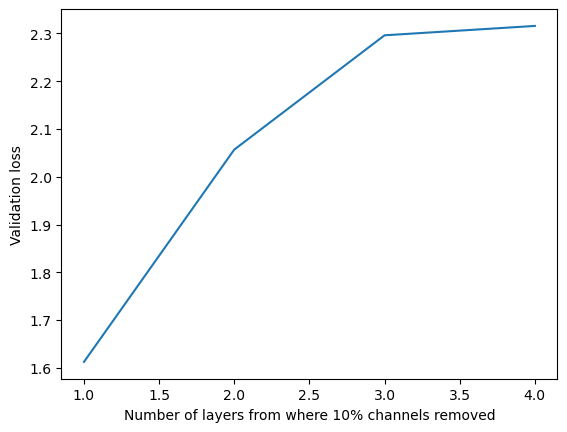

In [ ]:
sns.lineplot(x=list(cur_evals.keys()), y=list(cur_evals.values()))
plt.xlabel("Number of layers from where 10% channels removed")
plt.ylabel("Validation loss")

Text(0, 0.5, 'Loss')

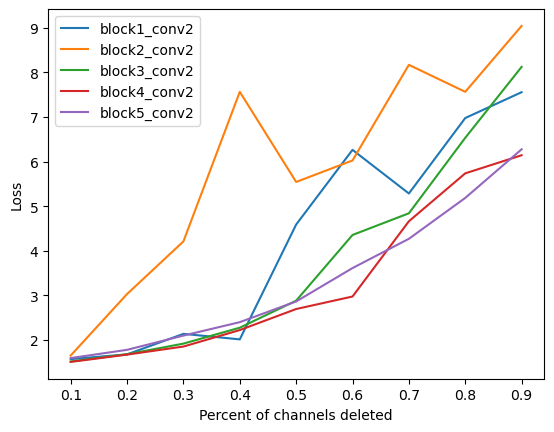

In [ ]:
# sns.lineplot(x=evals[list(evals.keys())[0]].keys(), y=[1.41]*len(evals[list(evals.keys())[0]]), label="unmutated")
for layer, eval in cur_evals.items():
    sns.lineplot(x=eval.keys(), y=[v for v in eval.values()], label=layer)
plt.xlabel("Percent of channels deleted")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

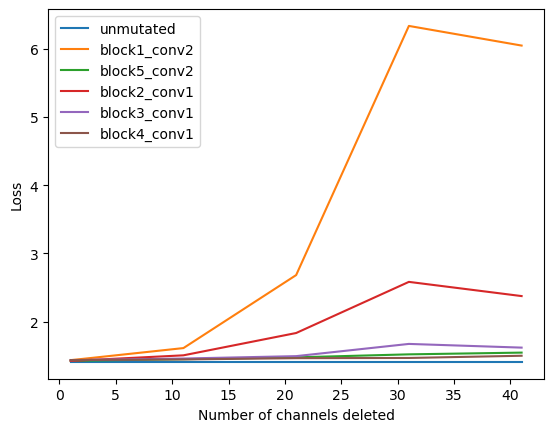

In [ ]:
sns.lineplot(x=evals[list(evals.keys())[0]].keys(), y=[1.41]*len(evals[list(evals.keys())[0]]), label="unmutated")
for layer, eval in evals.items():
    sns.lineplot(x=eval.keys(), y=[v['loss'] for v in eval.values()], label=layer)
plt.xlabel("Number of channels deleted")
plt.ylabel("Loss")

# Heuristic Channel Deletion

In [9]:
input_shape = model.input_shape
def summary_fn_dense(x): return x
def summary_fn_image(x):
    return np.linalg.norm(x, axis=tuple(range(1, len(x.shape)-1)), ord=2)

layers = list(map(lambda l: l.name, filter(lambda l: isinstance(l, ( tf.keras.layers.Conv2D,)), model.layers)))

all_labels = tf.keras.applications.imagenet_utils.decode_predictions(np.array([np.arange(1000)]), top=1000)[0]

selected_classes = np.random.choice(np.arange(len(all_labels)), 5, replace=False)

examplePerClass = 5

result = []


layer = 'block4_conv2'
next_layer = 'block4_conv3'
delete_percent = 0.5

for label in selected_classes:
    print(f'Label ({label}/{len(all_labels)}): {all_labels[label][1]}')
    @tf.function
    def filter_by_labels(X, y):
        return tf.reduce_any(tf.equal(y, [label]))
    @tf.function
    def filter_not_by_labels(X, y):
        return tf.reduce_any(tf.not_equal(y, [label]))
        
    classActivationSummary = {}

    img_count = 0
    for img, label_idx in ds['train'].filter(filter_by_labels).map(preprocess).batch(1):

        # Get activations
        activation = keract.get_activations(
            model, img, layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=False)

        for l, v in activation.items():
            if l not in classActivationSummary:
                classActivationSummary[l] = summary_fn_image(v)[0]
            else:
                classActivationSummary[l] += summary_fn_image(v)[0]

        img_count += 1
        if img_count >= examplePerClass:
            break
    
    result.append({})
    original_same = model.evaluate(ds['validation'].filter(filter_by_labels).map(preprocess).map(
            lambda x, y: (x, tf.one_hot(y, 1000))
        ).batch(32), verbose=0, return_dict=True)
    original_other = model.evaluate(ds['validation'].filter(filter_not_by_labels).map(preprocess).map(
            lambda x, y: (x, tf.one_hot(y, 1000))
        ).batch(32), verbose=0, return_dict=True)
    
    sorted_channels = classActivationSummary[layer].argsort()

    good_model = delete_cnn_layer_channel(
        model, layer, next_layer, channel_indices=sorted_channels[:int(len(sorted_channels)*delete_percent)], model_input_shape=input_shape)
    bottom_same = good_model.evaluate(ds['validation'].filter(filter_by_labels).map(preprocess).map(
            lambda x, y: (x, tf.one_hot(y, 1000))
        ).batch(32), verbose=0, return_dict=True)
    bottom_other = good_model.evaluate(ds['validation'].filter(filter_not_by_labels).map(preprocess).map(
            lambda x, y: (x, tf.one_hot(y, 1000))
        ).batch(32), verbose=0, return_dict=True)
        

    result[-1][f'original_same_accuracy'] = original_same['categorical_accuracy']
    result[-1][f'original_same_topkaccuracy'] = original_same['top_k_categorical_accuracy']
    result[-1][f'original_other_accuracy'] = original_other['categorical_accuracy']
    result[-1][f'original_other_topkaccuracy'] = original_other['top_k_categorical_accuracy']
    result[-1][f'bottom_{int(delete_percent*100)}_same_accuracy'] = bottom_same['categorical_accuracy']
    result[-1][f'bottom_{int(delete_percent*100)}_same_topkaccuracy'] = bottom_same['top_k_categorical_accuracy']
    result[-1][f'bottom_{int(delete_percent*100)}_other_accuracy'] = bottom_other['categorical_accuracy']
    result[-1][f'bottom_{int(delete_percent*100)}_other_topkaccuracy'] = bottom_other['top_k_categorical_accuracy']


    # bad_model = delete_cnn_layer_channel(
    #     model, layer, next_layer, channel_indices=sorted_channels[-int(len(sorted_channels)*delete_percent):], model_input_shape=input_shape)
    # top_same = bad_model.evaluate(ds['validation'].filter(filter_by_labels).map(preprocess).map(
    #         lambda x, y: (x, tf.one_hot(y, 1000))
    #     ).batch(32), verbose=0, return_dict=True)
    # top_other = bad_model.evaluate(ds['validation'].filter(filter_not_by_labels).map(preprocess).map(
    #         lambda x, y: (x, tf.one_hot(y, 1000))
    #     ).batch(32), verbose=0, return_dict=True)
    
    print(f'\tResult: {result[-1]}')
        
pd.DataFrame(result)

Label (388/1000): jigsaw_puzzle
	Result: {'original_same_accuracy': 0.8600000143051147, 'original_same_topkaccuracy': 0.9599999785423279, 'original_other_accuracy': 0.6568368077278137, 'original_other_topkaccuracy': 0.8665465712547302, 'bottom_50_same_accuracy': 0.8999999761581421, 'bottom_50_same_topkaccuracy': 1.0, 'bottom_50_other_accuracy': 0.3627827763557434, 'bottom_50_other_topkaccuracy': 0.6081882119178772}
Label (921/1000): tick
	Result: {'original_same_accuracy': 0.5600000023841858, 'original_same_topkaccuracy': 0.9200000166893005, 'original_other_accuracy': 0.6571371555328369, 'original_other_topkaccuracy': 0.8665865659713745, 'bottom_50_same_accuracy': 0.5, 'bottom_50_same_topkaccuracy': 0.9599999785423279, 'bottom_50_other_accuracy': 0.2560160160064697, 'bottom_50_other_topkaccuracy': 0.4715515375137329}
Label (627/1000): baboon
	Result: {'original_same_accuracy': 0.6800000071525574, 'original_same_topkaccuracy': 0.8399999737739563, 'original_other_accuracy': 0.65701699256

,original_same_accuracy,original_same_topkaccuracy,original_other_accuracy,original_other_topkaccuracy,bottom_50_same_accuracy,bottom_50_same_topkaccuracy,bottom_50_other_accuracy,bottom_50_other_topkaccuracy
0,0.86,0.96,0.656837,0.866547,0.90,1.00,0.362783,0.608188
1,0.56,0.92,0.657137,0.866587,0.50,0.96,0.256016,0.471552
2,0.68,0.84,0.657017,0.866667,0.74,0.90,0.328028,0.546386
3,0.84,0.92,0.656857,0.866587,0.76,0.96,0.309109,0.544424
4,0.24,0.82,0.657457,0.866687,0.24,0.80,0.208669,0.366146


<Axes: title={'center': 'Loss for each class'}, xlabel='Class', ylabel='Loss'>

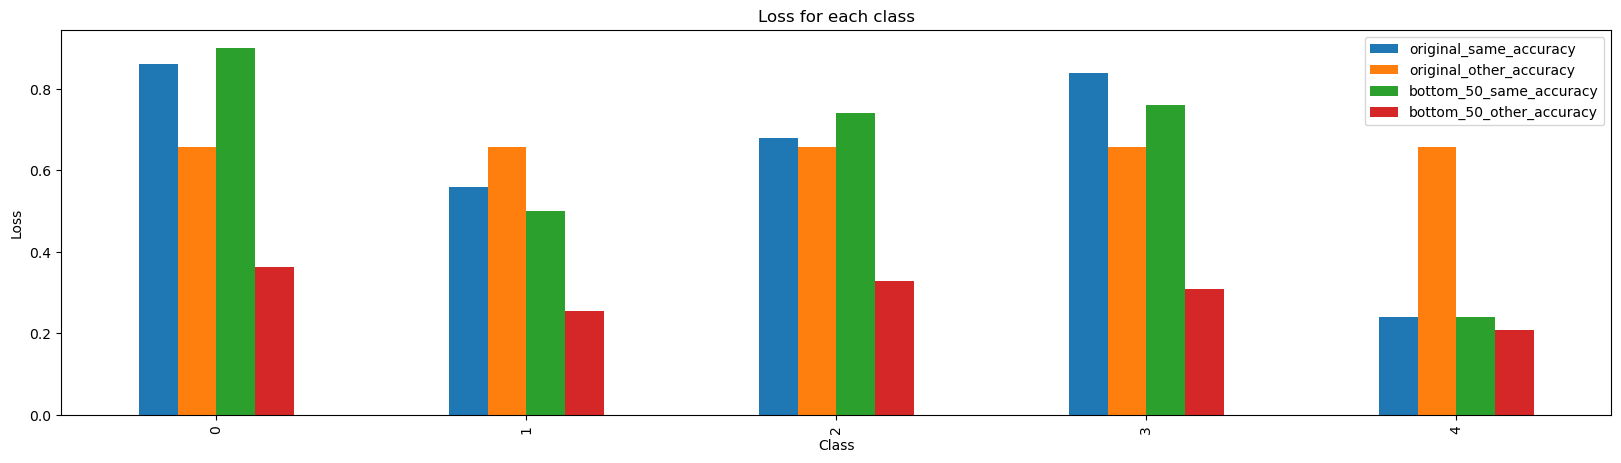

In [10]:
pd.DataFrame(result)[:5][["original_same_accuracy", "original_other_accuracy", "bottom_50_same_accuracy", "bottom_50_other_accuracy"]].plot.bar(figsize=(20,5), xlabel='Class', ylabel='Loss', title='Loss for each class')

<Axes: title={'center': 'Loss for each class'}, xlabel='Class', ylabel='Loss'>

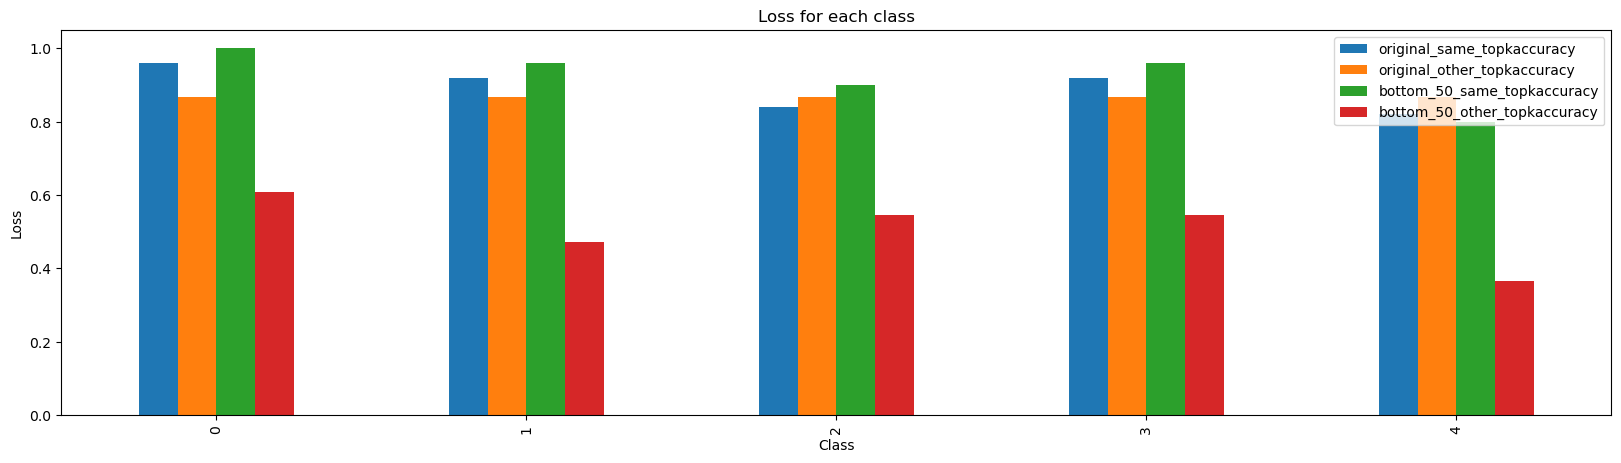

In [11]:
pd.DataFrame(result)[:5][["original_same_topkaccuracy", "original_other_topkaccuracy", "bottom_50_same_topkaccuracy", "bottom_50_other_topkaccuracy"]].plot.bar(figsize=(20,5), xlabel='Class', ylabel='Loss', title='Loss for each class')

# Class Intersection Approximation

In [9]:
labels = np.load('labels_imagenette.npz')['labels']
activationSummary = np.load('activationSummary_imagenette.npz')

activationSummary.files

['block1_conv1',
 'block1_conv2',
 'block2_conv1',
 'block2_conv2',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'flatten',
 'fc1',
 'fc2',
 'predictions']

In [54]:
def B(distribution1, distribution2):
    sq = np.zeros(len(distribution1))
    for i in range(len(distribution1)):
        sq  += np.sqrt(distribution1[i]*distribution2[i])
    
    return -np.log(sq)
    
def bhattacharyya_distance(d1, d2):
    return -np.log(np.linalg.norm(B(d1, d2)))

100%|██████████| 10/10 [00:00<00:00, 11.59it/s]
/tmp/ipykernel_3866/4263526730.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.linalg.norm(B(d1, d2)))


<Axes: >

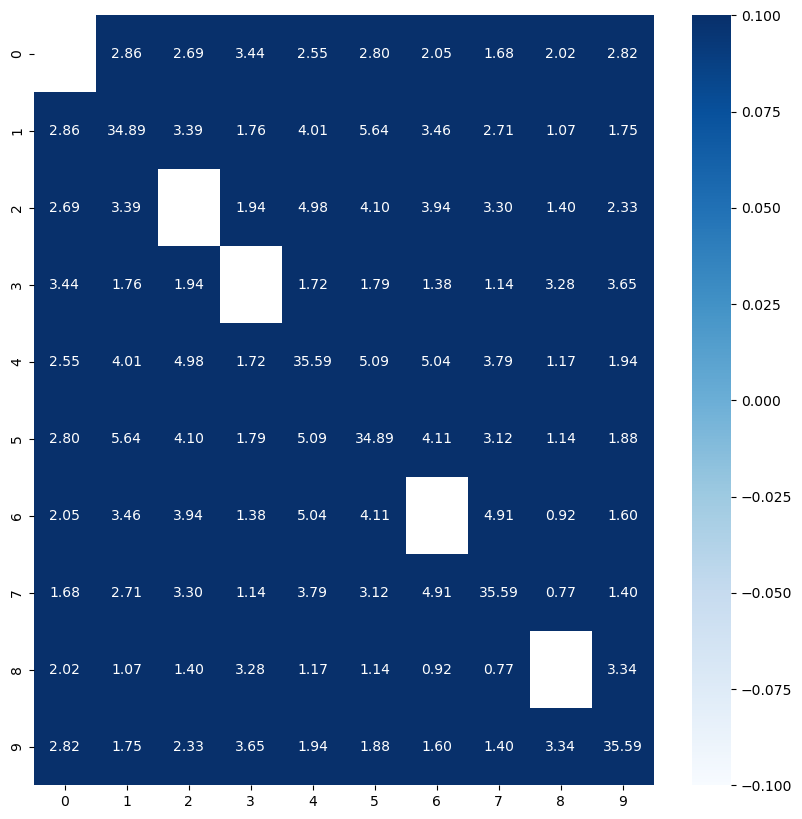

In [55]:
layer = 'block4_conv2'

alpha = 0.3
beta = 0.3
gamma = 0.3
point_clouds = []
for label in tqdm(range(10)):
    classActivationSummary = np.array([a for a, l in zip(activationSummary[layer], labels) if l == label])
    new_points = []
    for _ in range(1000):
        choices = np.random.choice(len(classActivationSummary), 3, replace=False)
        points = classActivationSummary[choices]
        new_points.append(alpha*points[0] + beta*points[1] + gamma*points[2])
    point_clouds.append(np.array(new_points))
point_clouds = np.array(point_clouds)
    
# create bhattacharyya distance matrix of point_clouds
bhattacharyya_matrix = np.zeros((10,10))
cosine_matrix = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        p1 = np.histogram(point_clouds[i], density=True)[0] + 0.000001
        p2 = np.histogram(point_clouds[j], density=True)[0] + 0.000001
        p1 /= np.sum(p1)
        p2 /= np.sum(p2)
        bhattacharyya_matrix[i,j] = bhattacharyya_distance(p1, p2)
        cosine_matrix[i,j] = spatial.distance.cosine(point_clouds[i].flatten(), point_clouds[j].flatten())

        
# plot bhattacharyya distance matrix with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(bhattacharyya_matrix, annot=True, fmt='.2f', cmap='Blues')


In [2]:
from matplotlib import pyplot as plt


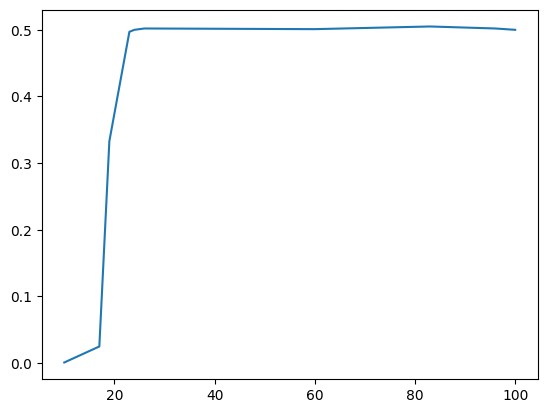

In [3]:
x = [100, 96, 83, 60, 26, 24, 23, 19, 17, 10]
mAP = [0.5, .502, .505, .501, .502, .5, .497, .333, .025, .001]
plt.plot(x, mAP)